In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/movie.csv


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from math import ceil
from tqdm import trange
from subprocess import call
from scipy.sparse import csr_matrix, dok_matrix

In [3]:
tag=pd.read_csv('/kaggle/input/movielens-20m-dataset/tag.csv')
rating=pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
movies=pd.read_csv('/kaggle/input/movielens-20m-dataset/movie.csv')
genome_scores=pd.read_csv('/kaggle/input/movielens-20m-dataset/genome_scores.csv')
link=pd.read_csv('/kaggle/input/movielens-20m-dataset/link.csv')
genome_tag=pd.read_csv('/kaggle/input/movielens-20m-dataset/genome_tags.csv')

# Коллаборативный подход

## Предобработка данных для коллаборативного подхода
Получение разреженной матрицы взаимодействий: строки - пользователи, столбцы - фильмы, содержимое - оценки пользователей для фильмов (рейтинги)

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
link.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [7]:
rating.shape

(20000263, 4)

In [8]:
rating['userId'].value_counts().shape ## unique users

(138493,)

In [9]:
def preprocess_data(rating, movies):
    x=rating['userId'].value_counts()>500
    y = x[x].index
    rating=rating[rating['userId'].isin(y)]
    movie_details=movies.merge(rating,on='movieId')
    movie_details.drop(columns=['timestamp'],inplace=True)
    number_rating = movie_details.groupby('title')['rating'].count().reset_index()
    number_rating.rename(columns={'rating':'number of rating'},inplace=True)
    df=movie_details.merge(number_rating,on='title')
    df=df[df['number of rating']>=50] #selecting valuable books by ratings
    df.drop_duplicates(['title','userId'],inplace=True)
    df.drop(columns=['number of rating'],inplace=True)
    df['rating']=df['rating'].astype(int)
    movie_pivot=df.pivot_table(columns='userId',index='title',values='rating')
    movie_pivot.fillna(0,inplace=True)
    movie_pivot.T
    return csr_matrix(movie_pivot.T), movie_pivot.T
    
    

In [10]:
df, int_matr = preprocess_data(rating, movies)

In [11]:
df

<7441x9359 sparse matrix of type '<class 'numpy.float64'>'
	with 6304274 stored elements in Compressed Sparse Row format>

In [12]:
mapping = movies[['title', 'movieId']]
mapper = {}
for i in range(len(mapping)):
    mapper[mapping.iloc[i,0]]=mapping.iloc[i,1]
int_matr.columns = int_matr.columns.map(mapper)
int_matr

title,26564,779,2072,3112,69757,8169,3420,6658,49284,8017,...,4696,5899,57274,74750,2600,51127,5507,33158,2478,5560
userId,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
54,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138397,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0
138406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
138411,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


### Разделим на train/test


Для разделения на train/test используем метод, который предлагает библиотека lightfm:

In [13]:
from lightfm.cross_validation import random_train_test_split

In [14]:
train, test = random_train_test_split(df, test_percentage=0.2)

In [31]:
train 

<7441x9359 sparse matrix of type '<class 'numpy.float32'>'
	with 5043419 stored elements in COOrdinate format>

In [16]:
test

<7441x9359 sparse matrix of type '<class 'numpy.float64'>'
	with 1260855 stored elements in COOrdinate format>

In [17]:
matrix_size = train.shape[0]*train.shape[1] 
num_purchases = len(train.nonzero()[0]) 
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

92.75790365061366

Разреженность матрицы - 92.76 процента. Для того, чтобы коллаборативная фильтрация работала, разреженность должна быть меньше 99,5 процентов, таким образом наши данные менее разреженны и коллаборативную фильтрацию можно использовать.

При реальной разработки модели мы бы проводили A/B тесты для оценки модели, и для трейна брали бы все доступные данные до какого-то момента времени, а все, что было бы дальше, использовали для теста.

### Выбор метрики для оценки качества работы модели
При разработке модели и выборе метрики для ее оценки необходимо прежде всего смотреть на требования бизнеса, и на то, сколько денег приносят результаты работы модели при использовании различных метрик - выбирали бы такую метрику, при оптимизации которой, модель приносила бы больший доход. 


Попробуем исользовать precision@k, auc

### Используем LightFM для коллаборативной фильтрации

In [18]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

In [19]:
def calculate_metrics(model, training_set, test_set):
    print('Calculating precision...')
    train_precision = precision_at_k(model, training_set, k=10).mean()
    test_precision = precision_at_k(model, test_set, k=10).mean()

    print('Calculating auc...')
    train_auc = auc_score(model, training_set).mean()
    test_auc = auc_score(model, test_set).mean()

    print('Precision@10: train %.3f, test %.3f.' % (train_precision, test_precision))
    print('AUC: train %.3f, test %.3f.' % (train_auc, test_auc))

In [ ]:
# При использовании лосса - Bayesian Personalised Ranking

model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=10,  num_threads=4, verbose=False)

calculate_metrics(model, train, test)

In [58]:
# При использовании лосса - Weighted Approximate-Rank Pairwise (оптимизирует recall_at_k)

model = LightFM(learning_rate=0.05, loss='warp')
model.fit_partial(train, epochs=10, num_threads=4, verbose=False)

calculate_metrics(model, train, test)
train_precision = precision_at_k(model, train, k=5).mean()
test_precision = precision_at_k(model, test, k=5).mean()
print('Precision@5: train %.3f, test %.3f.' % (train_precision, test_precision))

Calculating precision...
Calculating auc...
Precision@10: train 0.766, test 0.188.
AUC: train 0.926, test 0.900.
Precision@5: train 0.773, test 0.186.


In [ ]:
# При использовании лосса - k-OS WARP

model = LightFM(learning_rate=0.05, loss='warp-kos')
model.fit_partial(train, epochs=10, num_threads=4, verbose=False)

calculate_metrics(model, train, test)

In [ ]:
#Получили, что лучший лосс - 'warp'. Подберем лучшее no_components
for i in [8, 32, 64, 128]:
    print(f'no_components: {i}')
    model = LightFM(learning_rate=0.05, loss='warp', no_components = i)
    model.fit_partial(train, epochs=10, num_threads=4, verbose=False)
    calculate_metrics(model, train, test)

In [ ]:
# Будем использовать no_components = 32

In [20]:
# Посмотрим на сходимость модели
epochs = 50

adagrad_model = LightFM(no_components=32,
                        loss='warp',
                        learning_schedule='adagrad')
adadelta_model = LightFM(no_components=32,
                        loss='warp',
                        learning_schedule='adadelta')

adagrad_auc_test = []
adagrad_auc_train = []

for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc_test.append(auc_score(adagrad_model,test).mean())
    adagrad_auc_train.append(auc_score(adagrad_model,train).mean())
    


adadelta_auc_test = []
adadelta_auc_train = []

for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc_test.append(auc_score(adadelta_model, test).mean())
    adadelta_auc_train.append(auc_score(adadelta_model, train).mean())
    

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


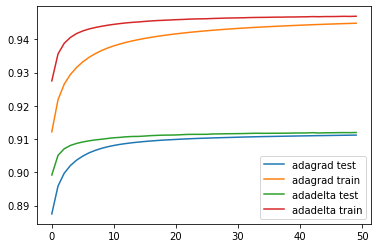

In [21]:
x = np.arange(len(adagrad_auc_test))
plt.plot(x, np.array(adagrad_auc_test), label = 'adagrad test')
plt.plot(x, np.array(adagrad_auc_train), label = 'adagrad train')

plt.plot(x, np.array(adadelta_auc_test), label = 'adadelta test')
plt.plot(x, np.array(adadelta_auc_train), label = 'adadelta train')

plt.legend(loc='lower right')
plt.show()

In [ ]:
# AdaDelta показыват лучшие результаты, скор модели выходит почти на плато после 15-20 эпох.

### ALS

Использование Alternating Least Squares

In [22]:
import scipy.sparse as sparse

In [23]:
class ALSWR:
    """
    Alternating Least Squares with Weighted Regularization
    for implicit feedback

    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm

    n_factors : int
        number/dimension of user and item latent factors

    alpha : int
        scaling factor that indicates the level of confidence in preference

    reg : int
        regularization term for the user and item latent factors

    seed : int
        seed for the randomly initialized user, item latent factors

    Reference
    ---------
    Y. Hu, Y. Koren, C. Volinsky Collaborative Filtering for Implicit Feedback Datasets
    http://yifanhu.net/PUB/cf.pdf
    """
    def __init__(self, n_iters, n_factors, alpha, reg, seed):
        self.reg = reg
        self.seed = seed
        self.alpha = alpha
        self.n_iters = n_iters
        self.n_factors = n_factors
    
    def fit(self, ratings):
        """
        ratings : scipy sparse csr_matrix [n_users, n_items]
            sparse matrix of user-item interactions
        """        

        Cui = ratings.copy().tocsr()
        Cui.data *= self.alpha
        Ciu = Cui.T.tocsr()
        self.n_users, self.n_items = Cui.shape
        
        rstate = np.random.RandomState(self.seed)
        self.user_factors = rstate.normal(size = (self.n_users, self.n_factors))
        self.item_factors = rstate.normal(size = (self.n_items, self.n_factors))
        
        for _ in trange(self.n_iters, desc = 'training progress'):
            self._als_step(Cui, self.user_factors, self.item_factors)
            self._als_step(Ciu, self.item_factors, self.user_factors)  
        
        return self
    
    def _als_step(self, Cui, X, Y):
 
        YtY = Y.T.dot(Y)
        data = Cui.data
        indptr, indices = Cui.indptr, Cui.indices

        for u in range(self.n_users):
           
            b = np.zeros(self.n_factors)
            A = YtY + self.reg * np.eye(self.n_factors)
            
            for index in range(indptr[u], indptr[u + 1]):
   
                i = indices[index]
                confidence = data[index] + 1
                factor = Y[i]


                b += confidence * factor

                A += (confidence - 1) * np.outer(factor, factor)

            X[u] = np.linalg.solve(A, b)
        
        return self

    def predict(self):
        """predict ratings for every user and item"""
        prediction = self.user_factors.dot(self.item_factors.T)
        return prediction
    
    def _predict_user(self, user):
        """
        returns the predicted ratings for the specified user,
        this is mainly used in computing evaluation metric
        """
        user_pred = self.user_factors[user].dot(self.item_factors.T)
        return user_pred

In [24]:
als = ALSWR(n_iters = 15, n_factors = 32, alpha = 15, reg = 0.01, seed = 42)
als.fit(train)

training progress: 100%|██████████| 15/15 [51:29<00:00, 205.98s/it]


In [25]:
def compute_apk(y_true, y_pred, k):

    actual = set(y_true)
    
    n_hit = 0
    precision = 0
    for i, p in enumerate(y_pred, 1):
        if p in actual:
            n_hit += 1
            precision += n_hit / i

    avg_precision = precision / min(len(actual), k)
    return avg_precision

In [26]:
def mapk_score(model, ratings, k):

    mapk = 0
    n_users = ratings.shape[0]
    for u in range(n_users):
        y_true = ratings[u].indices
        u_pred = model._predict_user(u)
        y_pred = np.argsort(u_pred)[::-1][:k]
        mapk += compute_apk(y_true, y_pred, k)

    mapk /= n_users
    return mapk

In [40]:
k = 5
mapk_train = mapk_score(als, csr_matrix(train), k)
mapk_test = mapk_score(als, csr_matrix(test), k)
print('mapk training:', mapk_train)
print('mapk testing:', mapk_test)

mapk training: 0.1995690543385724
mapk testing: 0.04973659454374453


In [41]:
k = 10
mapk_train = mapk_score(als, csr_matrix(train), k)
mapk_test = mapk_score(als, csr_matrix(test), k)
print('mapk training:', mapk_train)
print('mapk testing:', mapk_test)

mapk training: 0.21023117839170805
mapk testing: 0.03904206743845234


In [42]:
def ndcg_score(model, ratings, k):
  
    ndcg = 0.0
    n_users, n_items = ratings.shape
    for u in range(n_users):
        y_true = np.zeros(n_items)
        y_true[ratings[u].indices] = 1
        u_pred = model._predict_user(u)
        ndcg += ndcg_at_k(y_true, u_pred, k)
        
    avg_ndcg = ndcg / n_users
    return avg_ndcg


def ndcg_at_k(y_true, y_score, k = 10):

    actual = dcg_at_k(y_true, y_score, k)
    best = dcg_at_k(y_true, y_true, k) 
    ndcg = actual / best
    return ndcg


def dcg_at_k(y_true, y_score, k = 10):

    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, gains.size + 2))
    dcg = np.sum(gains / discounts)
    return dcg

In [43]:
k = 5
ndcg_train = ndcg_score(als, csr_matrix(train), k)
ndcg_test = ndcg_score(als, csr_matrix(test), k)
print('ndcg training:', ndcg_train)
print('ndcg testing:', ndcg_test)


ndcg training: 0.2980994260905798
ndcg testing: 0.09651757064233192


In [44]:
k = 10
ndcg_train = ndcg_score(als, csr_matrix(train), k)
ndcg_test = ndcg_score(als, csr_matrix(test), k)
print('ndcg training:', ndcg_train)
print('ndcg testing:', ndcg_test)

ndcg training: 0.3515360799693066
ndcg testing: 0.10458778852156368


# Content based

Использование информации о тегах, присвоенных фильмам. Кодируем теги с помощью TfidfVectorizer, затем снижаем размерность с помощью TruncatedSVD.

In [45]:
tag = tag.fillna('film')
tag.groupby('movieId').count()
item_tags = []
uni_movies = tag.movieId.unique()
for i in uni_movies:
    item_tags.append([[i], [' '.join(tag[tag.movieId == i].tag)]])
item_tags_np = np.array(item_tags)
item_tags = pd.DataFrame(item_tags_np.reshape(-1,2)[:,1], columns = ['tag'], index=item_tags_np.reshape(-1,2)[:,0])
print(item_tags)
vect = TfidfVectorizer()
X = vect.fit_transform(item_tags.tag)
svd = TruncatedSVD(n_components=500)
X1 = svd.fit_transform(X)
inter_items = pd.DataFrame(X1, index = item_tags.index)
final_items = inter_items.reindex(list(int_matr.columns.astype(str)))
(pd.isnull(final_items).any(1) == True).sum()
final_items = final_items.fillna(0)
final_items

                                                      tag
4141     Mark Waters naive Mark Waters Freddie Prinze Jr.
208     dark hero Kevin Costner adventure dystopia dys...
353     dark hero bittersweet cult film film noir ghos...
521     noir thriller neo-noir noir thriller neo-noir ...
592     dark hero dark dark hero adapted from:comic al...
...                                                   ...
103010           bittersweet friendship mourning roadtrip
113536                  corruption political thriller spy
113539  algeria based on a book colonialism history mo...
115373  alcoholism doctors French Louise Bourgoin love...
1495                                             retarded

[19545 rows x 1 columns]


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
26564,0.005149,0.007837,0.026731,-0.022946,0.004313,-0.000769,0.041082,0.006057,0.027452,-0.072600,...,-0.017277,0.058522,-0.009069,-0.023292,0.006673,-0.005837,0.004164,0.010998,0.005051,0.002823
779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2072,0.002621,0.008235,0.018269,-0.018289,0.005189,-0.000710,0.032888,0.005634,0.034373,-0.090662,...,-0.002932,0.003692,0.013788,0.015653,0.020424,0.019254,0.025421,0.016864,0.005122,-0.002230
3112,0.009149,0.011660,0.131328,0.057122,-0.014724,0.010072,0.053369,-0.009777,-0.016877,0.007289,...,0.003076,0.038368,0.007160,-0.014477,0.005997,0.012217,-0.000942,0.006339,-0.016075,0.015169
69757,0.003644,0.009611,0.025007,-0.023969,0.005810,-0.000743,0.042835,0.008036,0.027046,-0.077596,...,-0.016220,0.002039,-0.000105,0.013449,-0.008135,-0.021999,-0.015942,0.006547,0.005738,0.019135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51127,0.008554,0.010230,0.094747,-0.171294,-0.052510,0.298771,-0.058652,0.002567,0.017361,-0.043044,...,0.008710,0.008378,0.019531,-0.012553,0.012436,0.005273,-0.002703,-0.000249,0.007788,0.011259
5507,0.006800,0.007122,0.035020,-0.029922,0.040080,-0.009724,0.017231,-0.002628,0.012177,-0.031901,...,0.005042,-0.000999,-0.032887,0.000704,0.001450,-0.005135,-0.034212,-0.001504,-0.000831,0.036335
33158,0.003896,0.008000,0.029212,-0.035688,-0.013604,-0.019526,0.026682,-0.002858,0.014443,-0.042511,...,-0.005271,-0.006144,0.004604,0.005346,0.000487,-0.017393,0.012653,0.013872,-0.005810,-0.014427
2478,0.006190,0.013258,0.040184,-0.035132,0.004734,-0.003302,0.057061,0.005916,0.053245,-0.135820,...,0.047134,-0.015837,0.042848,-0.046776,-0.026492,0.003731,-0.024735,-0.033788,0.012829,0.045476


In [46]:
df.shape

(7441, 9359)

In [47]:
final_items.shape

(9359, 500)

In [48]:
# Import the model
from lightfm import LightFM

NUM_THREADS = 4
NUM_COMPONENTS = 32
NUM_EPOCHS = 3

In [49]:
model = LightFM(loss='warp',
                learning_schedule='adagrad',
                no_components=NUM_COMPONENTS)

model = model.fit(train,
                item_features=csr_matrix(final_items),
                epochs=NUM_EPOCHS,
                num_threads=NUM_THREADS, verbose = True)

Epoch 0
Epoch 1
Epoch 2


In [52]:
train_auc = auc_score(model,
                      train,
                      item_features=csr_matrix(final_items),
                      num_threads=NUM_THREADS).mean()
test_auc = auc_score(model,
                    test,
                    train_interactions=train,
                    item_features=csr_matrix(final_items),
                    num_threads=NUM_THREADS).mean()
print('Hybrid test set AUC: %s' % test_auc)
print('Hybrid training set AUC: %s' % train_auc)

Hybrid test set AUC: 0.8667676
Hybrid training set AUC: 0.86221635


In [56]:
train_precision_at_10 = precision_at_k(model,
                                  train,
                                  item_features=csr_matrix(final_items),
                                  num_threads=NUM_THREADS,
                                  k=10).mean()
test_precision_at_10 = precision_at_k(model,
                                 test,
                                 train_interactions=train,
                                 item_features=csr_matrix(final_items),
                                 num_threads=NUM_THREADS,
                                 k = 10).mean()
print('Hybrid test set precision@10: %s' % test_precision_at_10)
print('Hybrid training set precision@10: %s' % train_precision_at_10)

Hybrid test set precision@10: 0.57810783
Hybrid training set precision@10: 0.72803384


Таким образом, гибридная модель, хоть и дает немного меньшие скоры, гораздо лучше справляется с проблемой холодного старта - precision@10 на тест - 0.58, что  значительно больше результата, полученного ранее.

# Выводы

Используемые модели дают достаточно высокие AUC. Тем не менее имеем проблему холодного страта, с которой помогает справиться гибридный подход - дополнительное использование тегов, присвоенных фильмам. Такая модель хоть и имеет несколько меньшее значение AUC, тем не менее имеет меньший разброс между предсказаниями на трейне и тесте, и потенциально значение метрики можно улучшить путем более долгого обучения модели и более качественного подбора гипперпараметров.